### LangGraph : Highly customizable and flexible Agents

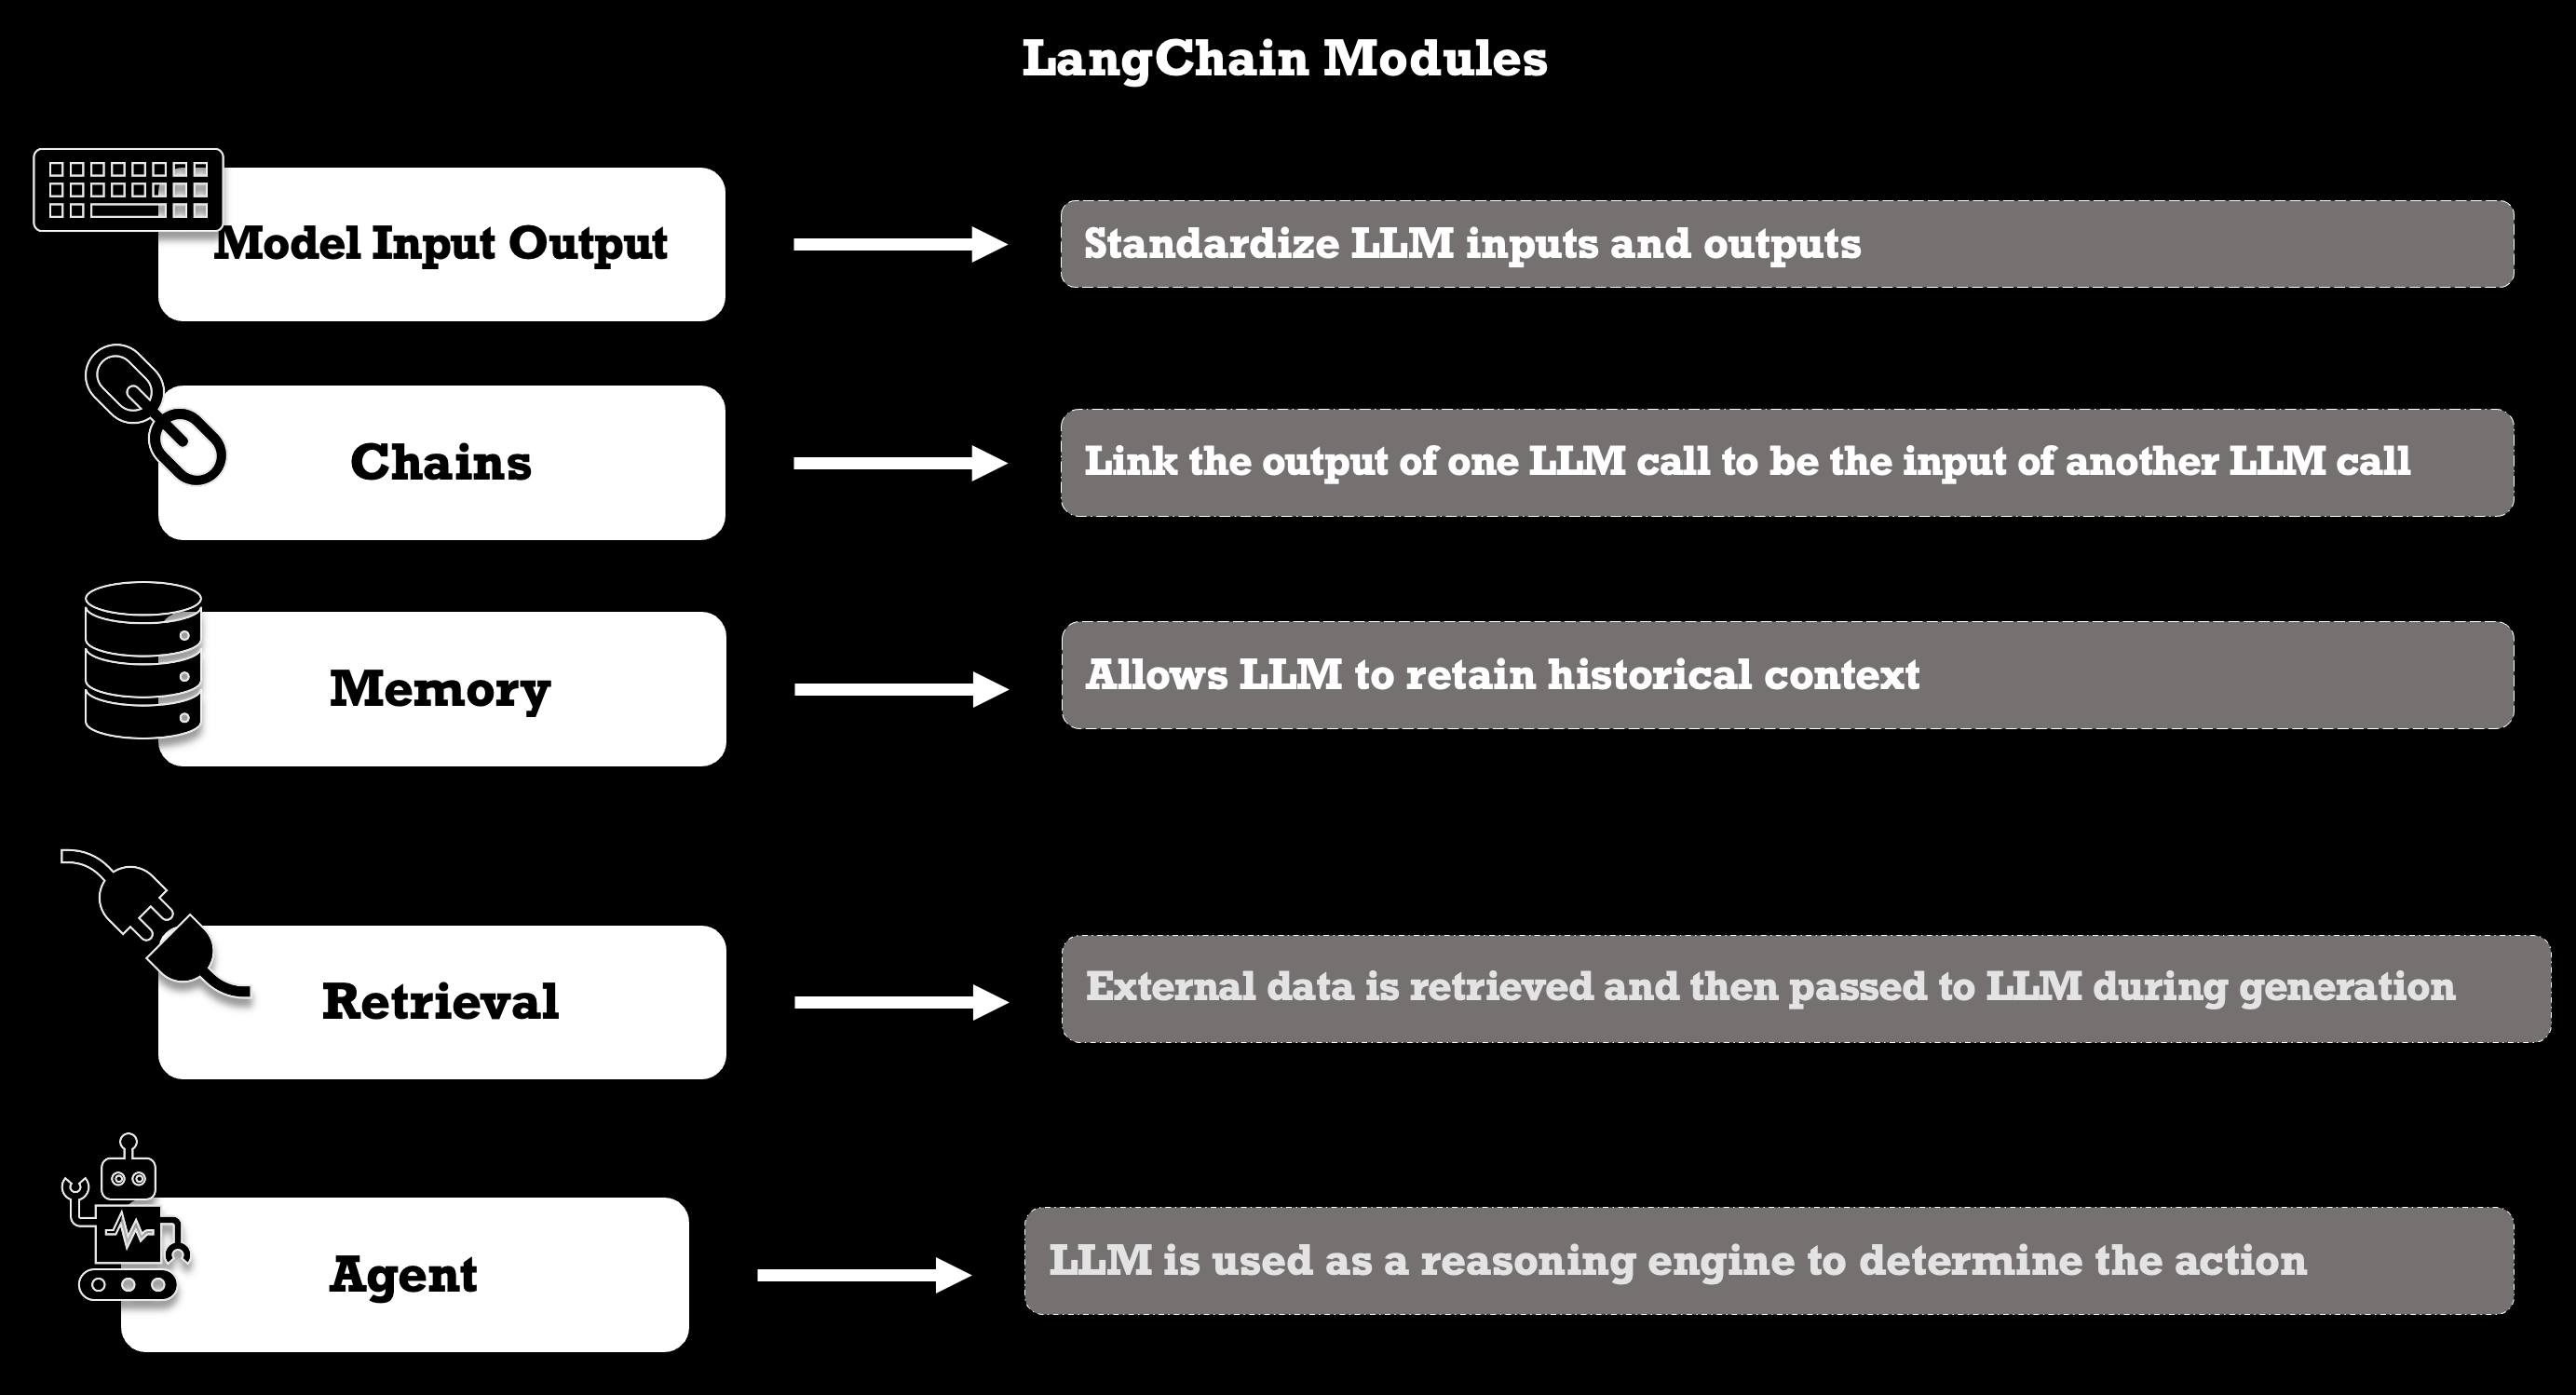

In [1]:
from IPython.display import Image
Image(filename='LC.png',width=1000)

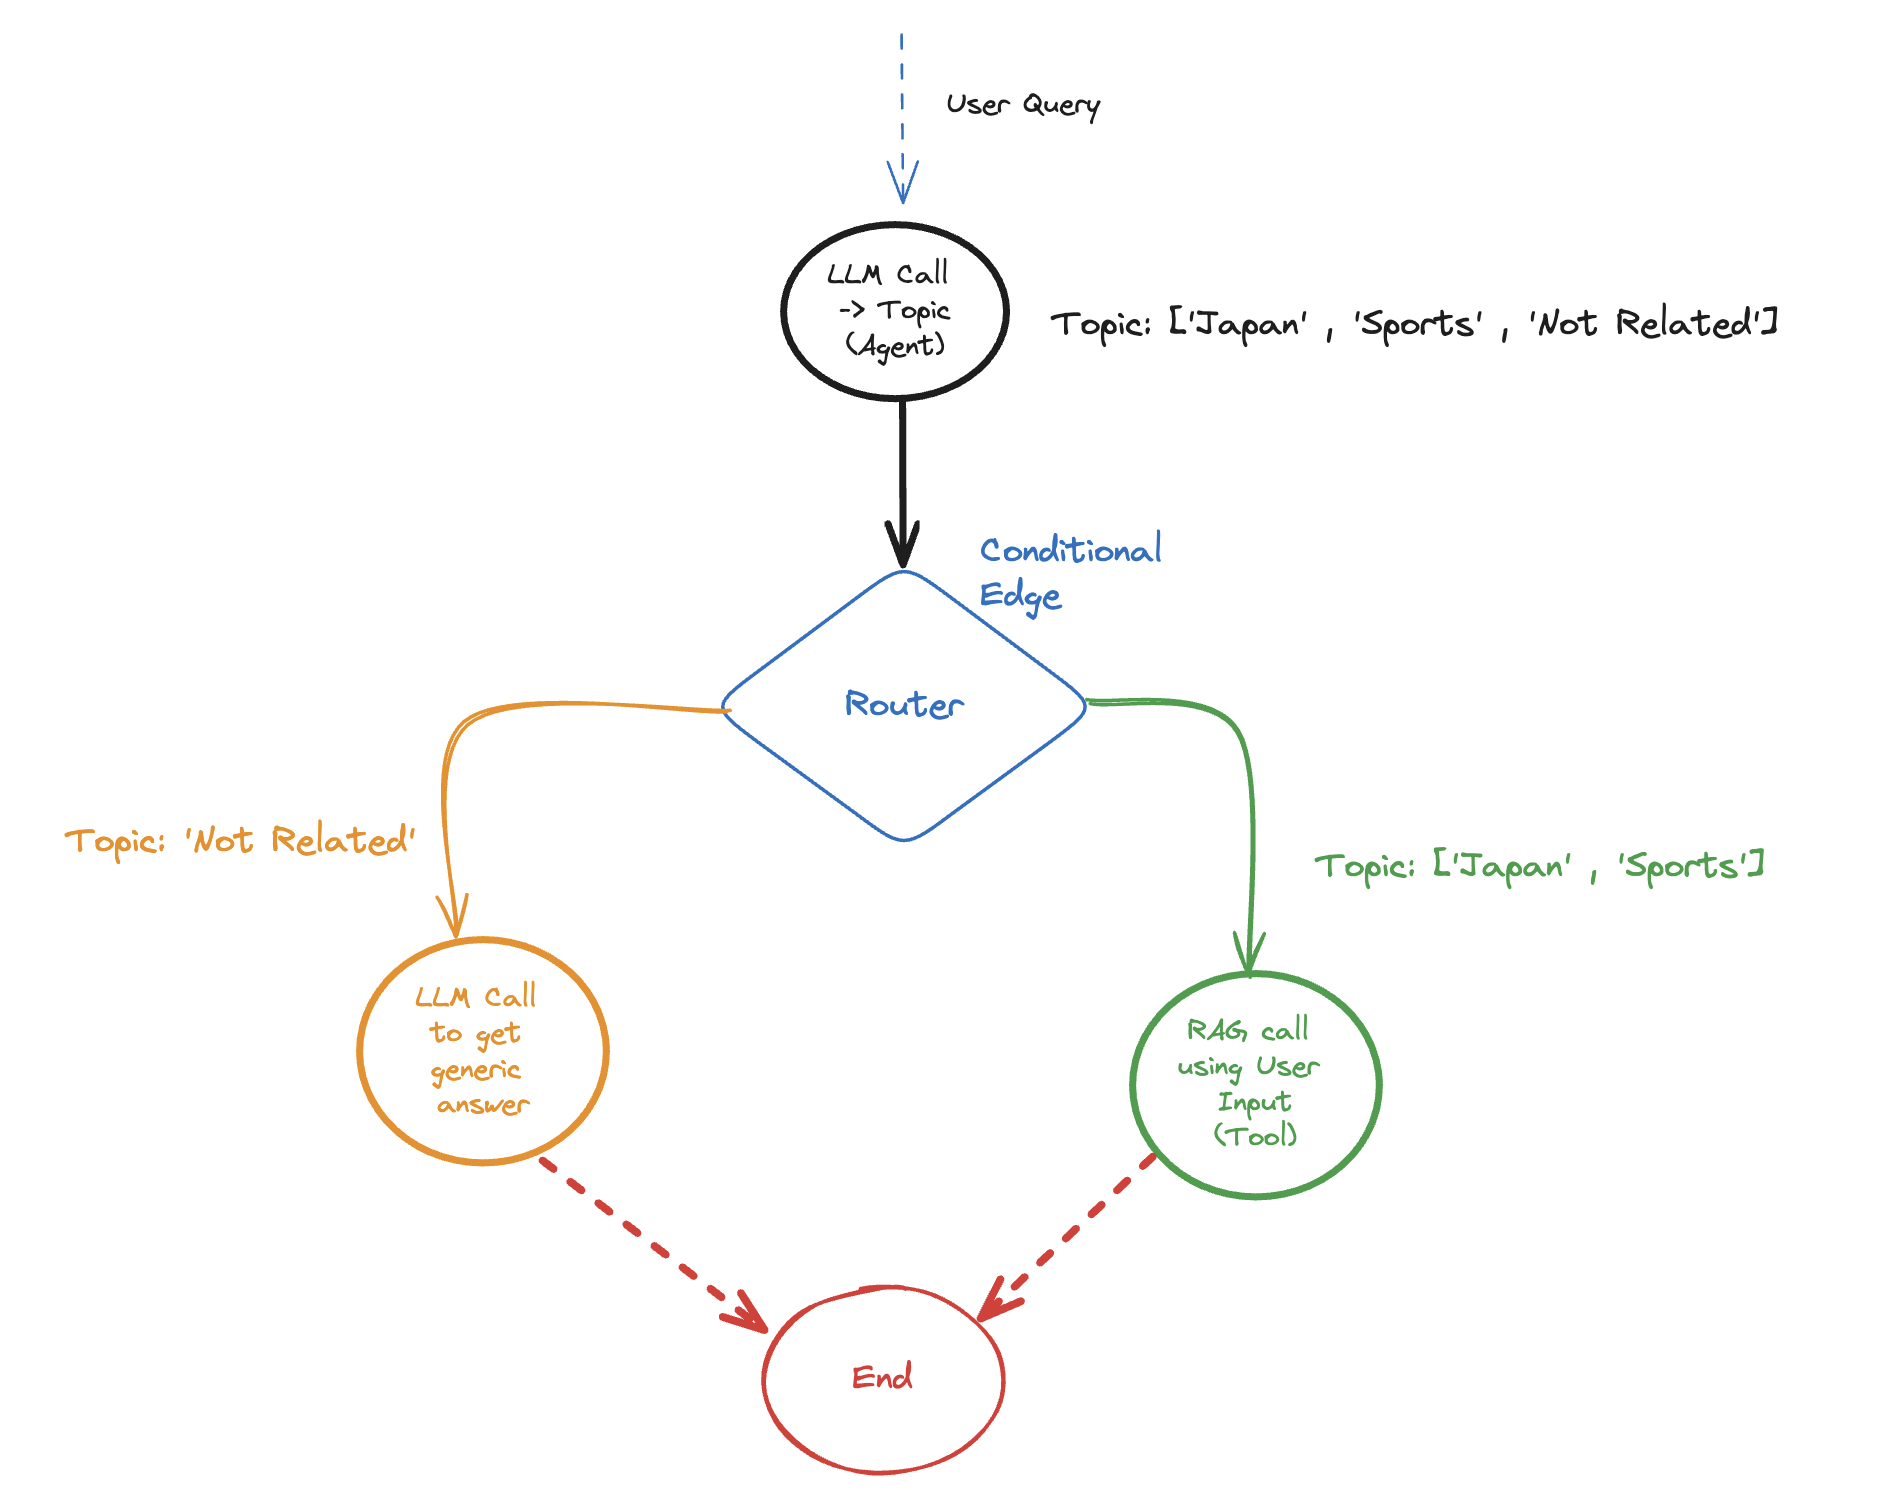

In [2]:
from IPython.display import Image
Image(filename='LG_6.png',width=800)

In [3]:
! pip install langgraph
! pip install langchain_openai

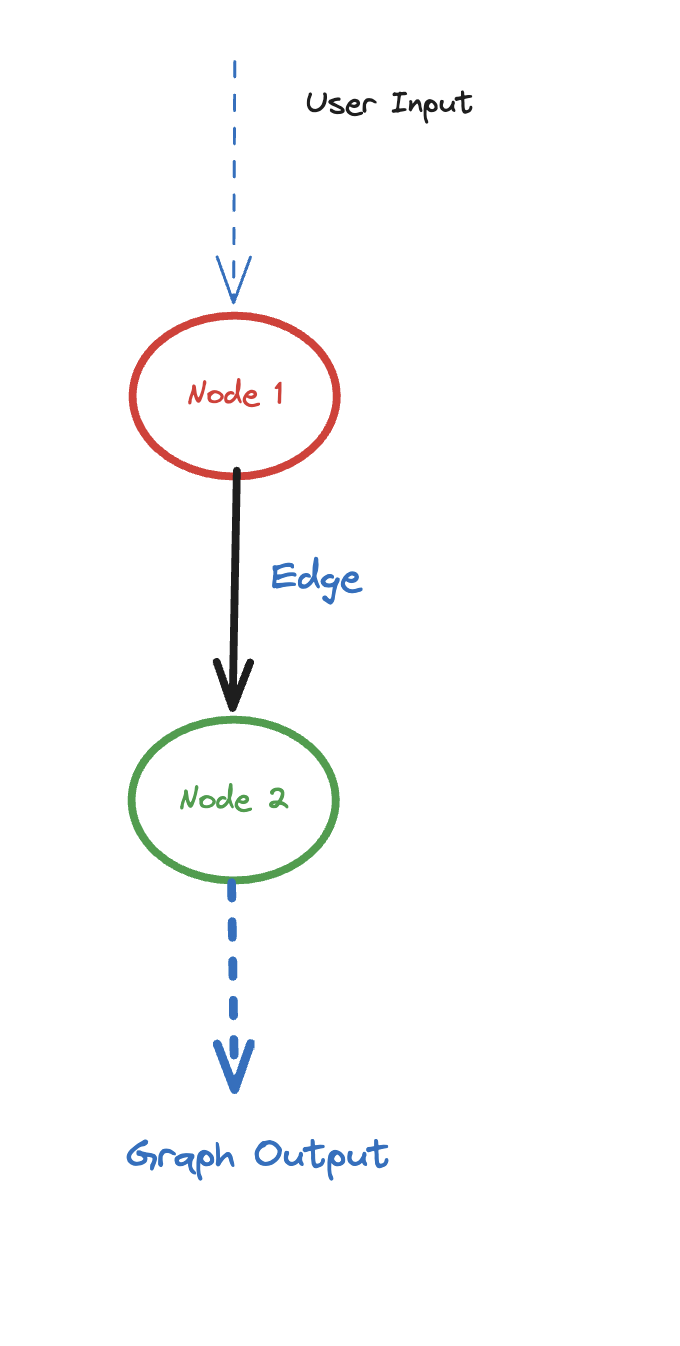

In [4]:
from IPython.display import Image
Image(filename='LG_1.png',width=400)

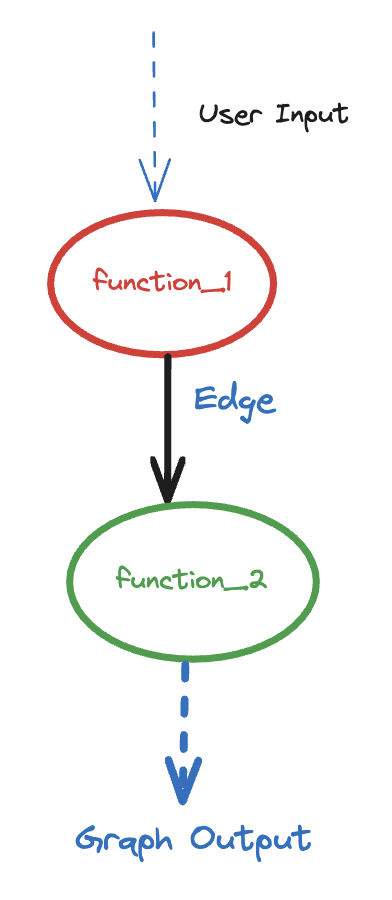

In [5]:
from IPython.display import Image
Image(filename='LG_2.png',width=300) 

In [6]:
def function_1(input_1):
    return input_1 + " First Function "

def function_2(input_2):
    return input_2 + " to Second Function"

In [7]:
from langgraph.graph import Graph

# Define a Langchain graph
workflow = Graph()

workflow.add_node("node_1", function_1)
workflow.add_node("node_2", function_2)

workflow.add_edge('node_1', 'node_2')

workflow.set_entry_point("node_1")
workflow.set_finish_point("node_2")

app = workflow.compile()

In [8]:
app.invoke('I am moving from')

'I am moving from First Function  to Second Function'

In [10]:
input = 'I am moving from'
for output in app.stream(input):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'node_1':
---
I am moving from First Function 

---

Output from node 'node_2':
---
I am moving from First Function  to Second Function

---



### Integrating LLM call in the LangGraph

In [11]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [12]:
TOGETHER_API_KEY = os.getenv("TOGETHER_API_KEY")

In [13]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(base_url="https://api.together.xyz/v1",
    api_key=TOGETHER_API_KEY,
    model="mistralai/Mistral-7B-Instruct-v0.2",
    temperature=0.0)

In [14]:
llm.invoke('Hi').content

" Hello! How can I help you today? If you have any questions or need assistance with something, feel free to ask. I'm here to help. If you just want to chat or share some thoughts, that's fine too. Let me know what's on your mind."

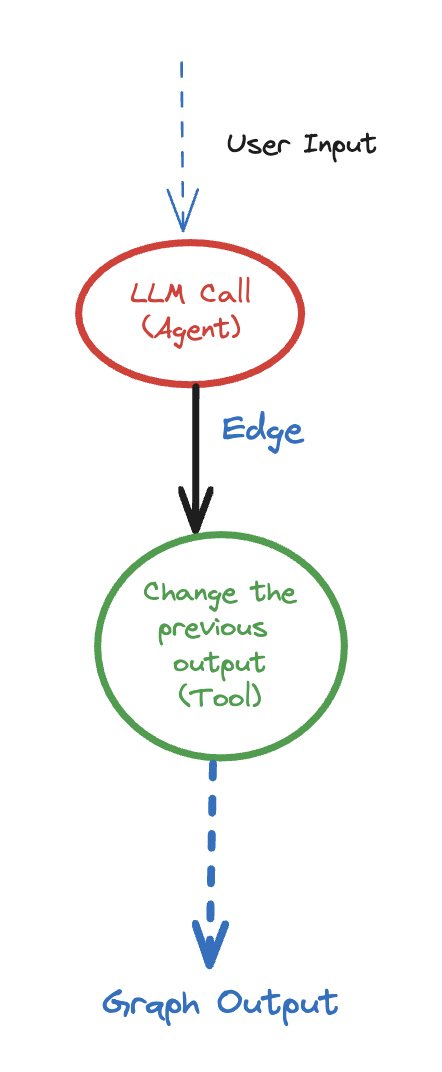

In [15]:
from IPython.display import Image
Image(filename='LG_3.png',width=300) 

In [16]:
def function_1(input_1):
    complete_query = "Your task is to provide only the topic based on the user query. \
        Only output the topic among: [Japan , Sports]. Don't include reasoning. Following is the user query: " + input_1
    response = llm.invoke(complete_query)
    return response.content

def function_2(input_2):
    TOPIC_UPPER = input_2.upper()
    response = f"Here is the topic in UPPER case: {TOPIC_UPPER}"
    return response

In [17]:
# Define a Langchain graph
workflow = Graph()

workflow.add_node("Agent", function_1)
workflow.add_node("tool", function_2)

workflow.add_edge('Agent', 'tool')

workflow.set_entry_point("Agent")
workflow.set_finish_point("tool")

app = workflow.compile()

In [18]:
query = "Tell me about Japan's Industrial Growth"
app.invoke(query)

'Here is the topic in UPPER case:  TOPIC: JAPAN.\n\n(NOTE: WHILE THE USER QUERY DOES NOT EXPLICITLY MENTION IT, THE TOPIC OF "JAPAN\'S INDUSTRIAL GROWTH" CAN BE INFERRED FROM THE CONTEXT. HOWEVER, SINCE THE TASK IS TO PROVIDE ONLY THE TOPIC AND NOT THE SPECIFIC SUB-TOPIC, THE TOPIC OF "JAPAN" IS SUFFICIENT.)'

In [19]:
for output in app.stream(query):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'Agent':
---
 Topic: Japan.

(Note: While the user query does not explicitly mention it, the topic of "Japan's Industrial Growth" can be inferred from the context. However, since the task is to provide only the topic and not the specific sub-topic, the topic of "Japan" is sufficient.)

---

Output from node 'tool':
---
Here is the topic in UPPER case:  TOPIC: JAPAN.

(NOTE: WHILE THE USER QUERY DOES NOT EXPLICITLY MENTION IT, THE TOPIC OF "JAPAN'S INDUSTRIAL GROWTH" CAN BE INFERRED FROM THE CONTEXT. HOWEVER, SINCE THE TASK IS TO PROVIDE ONLY THE TOPIC AND NOT THE SPECIFIC SUB-TOPIC, THE TOPIC OF "JAPAN" IS SUFFICIENT.)

---



### RAG Pipeline integration

In [20]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma

### Reading the txt files from source directory

loader = DirectoryLoader('./source', glob="./*.txt", loader_cls=TextLoader)
docs = loader.load()

### Creating Chunks using RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=10,
    length_function=len
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

###  BGE Embddings

from langchain.embeddings import HuggingFaceBgeEmbeddings

model_name = "BAAI/bge-base-en-v1.5"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity
embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
)

### Creating Retriever using Vector DB

db = Chroma.from_documents(new_docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 4})

/Users/aritra.sen/Aritra/coding/my_llm_app/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/aritra.sen/Aritra/coding/my_llm_app/.venv/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/Users/aritra.sen/Aritra/coding/my_llm_app/.venv/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


### Testing the retriever

In [21]:
query = "Tell me about Japan's Industrial Growth"
docs = retriever.get_relevant_documents(query)
print(docs)

[Document(page_content='Industrial revival hope for Japan', metadata={'source': 'source/japan.txt'}), Document(page_content="Japanese industry is growing faster than expected, boosting hopes that the country's retreat back", metadata={'source': 'source/japan.txt'}), Document(page_content="exports, normally the engine for Japan's economy in the face of weak domestic demand, had helped", metadata={'source': 'source/japan.txt'}), Document(page_content='Industrial output rose 2.1% - adjusted for the time of year - in January from a month earlier. At', metadata={'source': 'source/japan.txt'})]


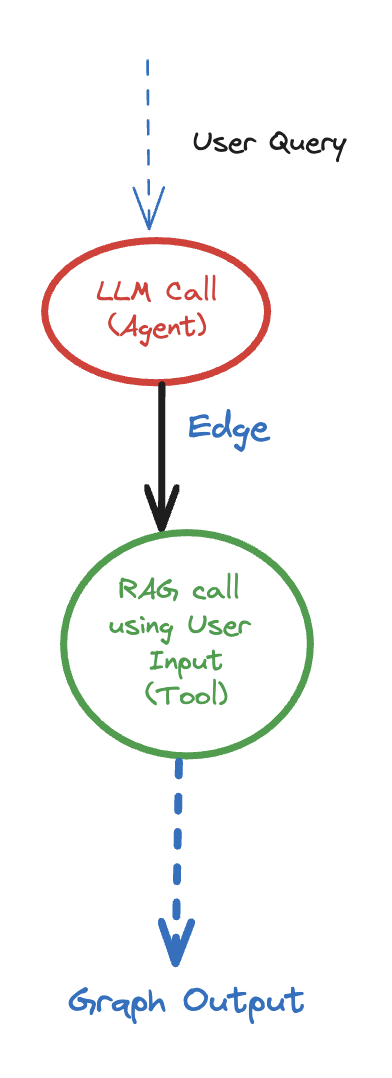

In [22]:
from IPython.display import Image
Image(filename='LG_4.png',width=200) 

### Integrating RAG pipeline with LangGraph and AgentState

In [23]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain.chains import RetrievalQA

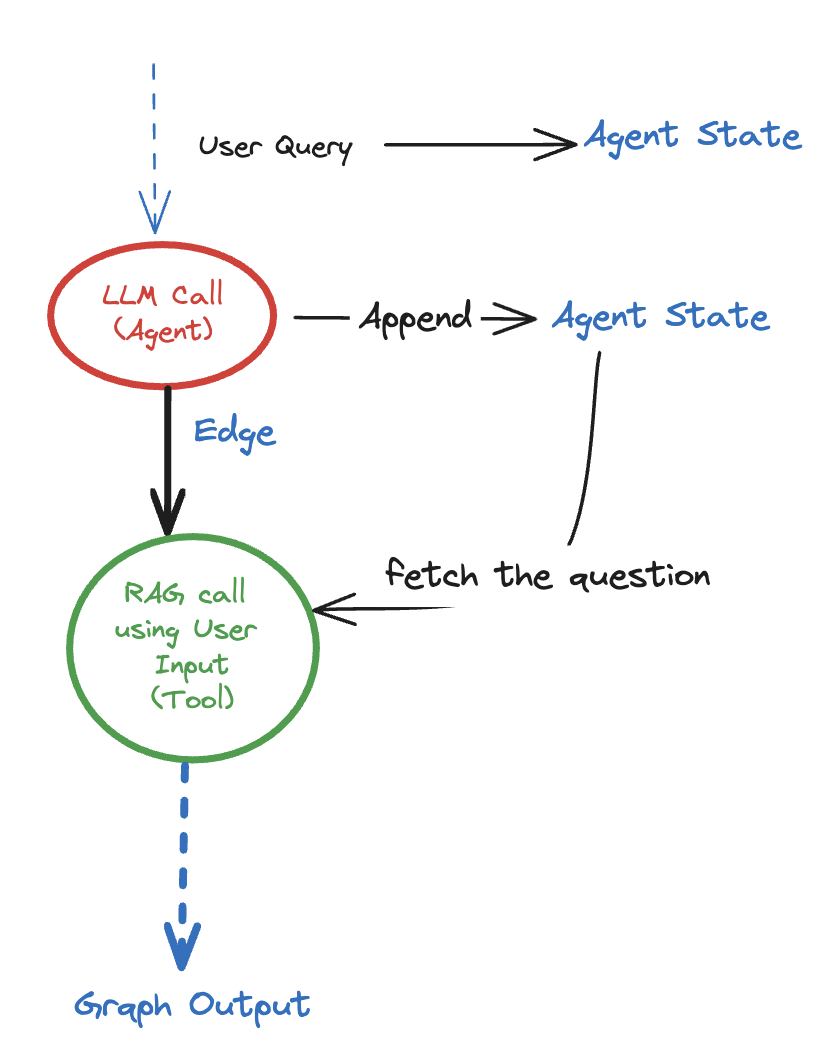

In [24]:
from IPython.display import Image
Image(filename='LG_5.png',width=400)

In [25]:
# assign AgentState as an empty dict
AgentState = {}

# messages key will be assigned as an empty array. We will append new messages as we pass along nodes. 
AgentState["messages"] = []

In [26]:
AgentState

{'messages': []}

In [27]:
def function_1(state):
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    
    complete_query = "Your task is to provide only the topic based on the user query. \
        Only output the topic among: [Japan , Sports]. Don't include reasoning. Following is the user query: " + question
    response = llm.invoke(complete_query)
    state['messages'].append(response.content) # appending LLM call response to the AgentState
    return state

def function_2(state):
    messages = state['messages']
    question = messages[0] ## Fetching the user question

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return result

In [28]:
# Define a Langchain graph
workflow = Graph()

workflow.add_node("Agent", function_1)
workflow.add_node("tool", function_2)

workflow.add_edge('Agent', 'tool')

workflow.set_entry_point("Agent")
workflow.set_finish_point("tool")

app = workflow.compile()

In [29]:
inputs = {"messages": ["Tell me about Japan's Industrial Growth"]}
app.invoke(inputs)

" According to the given context from the 'source/japan.txt' document, Japan's industrial growth is currently experiencing a faster rate than what was previously expected. This growth is contributing to renewed hopes that the country's economy may be reviving after a period of retreat. Exports, which have historically driven Japan's economy due to weak domestic demand, have also played a role in this growth. Specifically, industrial output increased by 2.1% in January compared to the previous month, after adjusting for seasonal variations."

In [30]:
inputs = {"messages": ["Who came fourth for Ireland at the outdoor European Running Championships in 1998?"]}
app.invoke(inputs)

' McIlroy is the person who came fourth for Ireland at the outdoor European Running Championships in 1998, according to the context provided.'

In [31]:
for output in app.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'Agent':
---
{'messages': ['Who came fourth for Ireland at the outdoor European Running Championships in 1998?', ' The topic of the user query is: Sports.', ' The topic is: Sports.']}

---

Output from node 'tool':
---
 McIlroy is the person who came fourth for Ireland at the outdoor European Running Championships in 1998, according to the context provided.

---



### Simplyfying the State addition and maintainence

In [28]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

### Making Complex Graphs with Conditional Edges

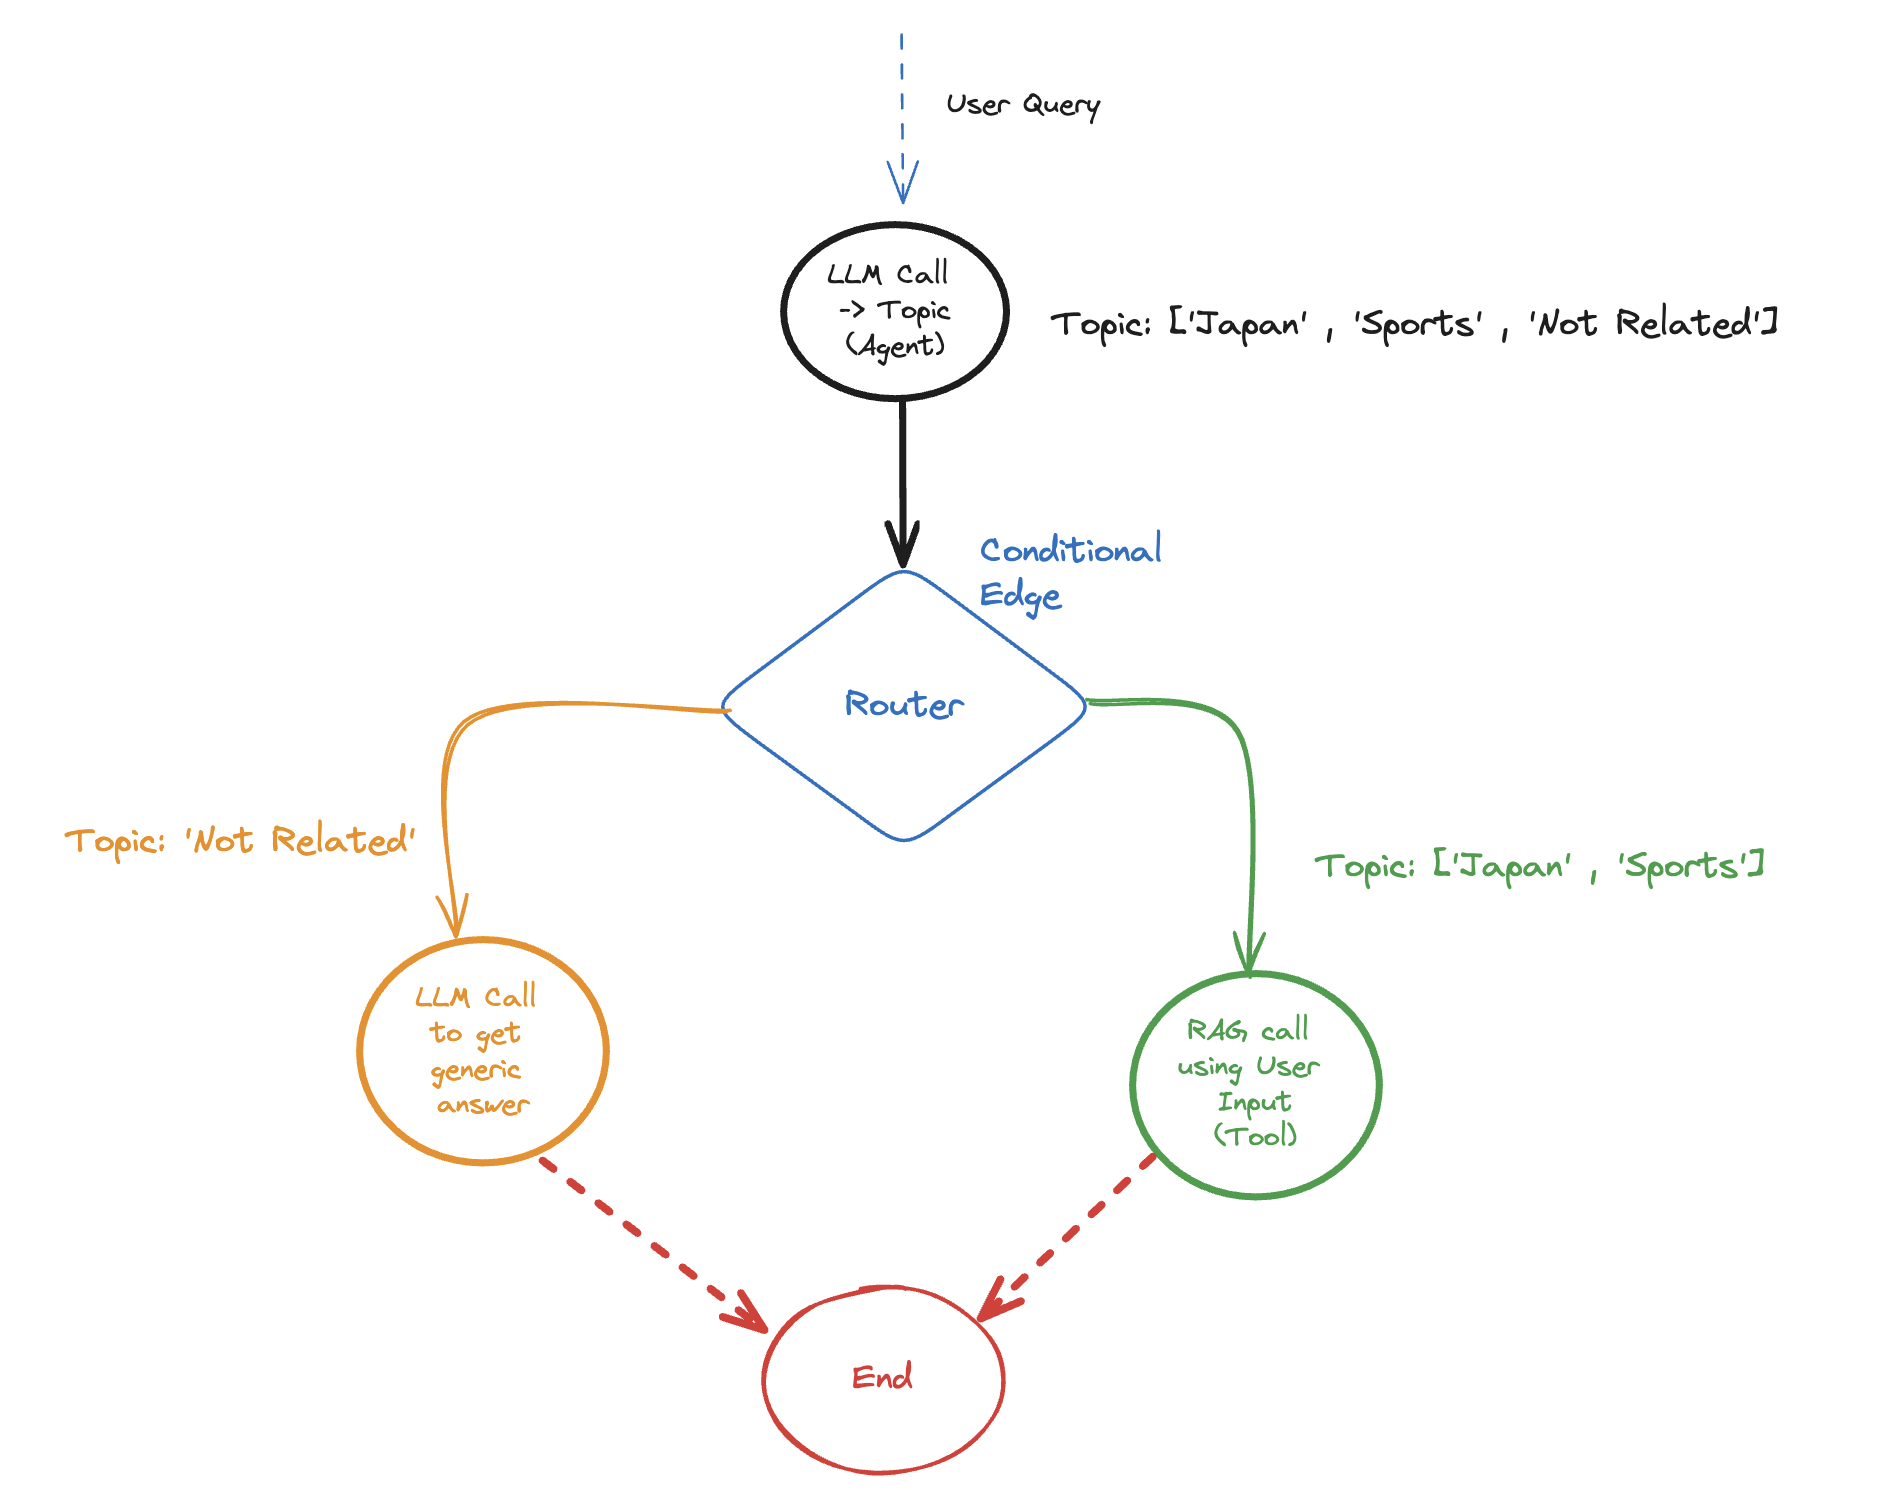

In [147]:
from IPython.display import Image
Image(filename='LG_6.png',width=800)

In [100]:
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate


class TopicSelectionParser(BaseModel):
    Topic: str = Field(description='Selected Topic')
    #Reasoning: str = Field(description='Reasoning behind topic selection')

parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [115]:
def function_1(state):
    print('-> Calling Agent ->')
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    
    templete = """ Your task is to provide only the topic based on the user query. 
        Only output the topic among: [Japan , Sports , Not Related]. Don't include reasoning. Following is the user query:  {question}
        {format_instructions} """
    prompt = PromptTemplate(template=templete,
                                    input_variables=[question],
                                    partial_variables={
                                        "format_instructions" : parser.get_format_instructions()                                    }
                                    )
    chain = prompt | llm | parser

    response = chain.invoke({"question":question,"format_instructions" : parser.get_format_instructions() })

    print(response)

    return {"messages": [response.Topic]}

def function_2(state):
    print('-> Calling RAG ->')
    messages = state['messages']
    question = messages[0] ## Fetching the user question

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return  {"messages": [result]}

def function_3(state):
    print('-> Calling LLM ->')

    messages = state['messages']
    question = messages[0] ## Fetching the user question

    # Normal LLM call
    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages": [response.content]}


def router(state):
    print('-> Router ->')
    
    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)
    if 'Japan' in last_message or 'Sports' in last_message:
        return 'RAG Call'
    else:
        return 'LLM Call'


In [116]:
from langgraph.graph import StateGraph,END

graph = StateGraph(AgentState) ### StateGraph with AgentState

graph.add_node("agent", function_1)
graph.add_node("RAG", function_2)
graph.add_node("LLM", function_3)

graph.set_entry_point("agent")


# conditional edges are controlled by our router
graph.add_conditional_edges(
    start_key="agent",  # where in graph to start
    condition=router,  # function to determine which node is called
    conditional_edge_mapping={
        "RAG Call": "RAG",
        "LLM Call": "LLM",
    }
)

graph.add_edge("RAG", END)
graph.add_edge("LLM", END)

app = graph.compile()

In [89]:
# from IPython.display import Image

# Image(app.get_graph().draw_png())

In [117]:
inputs = {"messages": ["Tell me about Japan's Industrial Growth"]}
out = app.invoke(inputs)

-> Calling Agent ->
Topic='Japan'
-> Router ->
Japan
-> Calling RAG ->


In [118]:
out['messages']

["Tell me about Japan's Industrial Growth",
 'Japan',
 " According to the given context from the 'source/japan.txt' document, Japan's industrial growth is currently experiencing a faster rate than what was previously expected. This growth is contributing to renewed hopes that the country's economy may be reviving after a period of retreat. Exports, which have historically driven Japan's economy due to weak domestic demand, have also played a role in this growth. Specifically, industrial output increased by 2.1% in January compared to the previous month, after adjusting for seasonal variations."]

In [119]:
out['messages'][-1]

" According to the given context from the 'source/japan.txt' document, Japan's industrial growth is currently experiencing a faster rate than what was previously expected. This growth is contributing to renewed hopes that the country's economy may be reviving after a period of retreat. Exports, which have historically driven Japan's economy due to weak domestic demand, have also played a role in this growth. Specifically, industrial output increased by 2.1% in January compared to the previous month, after adjusting for seasonal variations."

In [120]:
inputs = {"messages": ["Who came fourth for Ireland at the outdoor European Running Championships in 1998?"]}
out = app.invoke(inputs)
print(out)

-> Calling Agent ->
Topic='Sports'
-> Router ->
Sports
-> Calling RAG ->
{'messages': ['Who came fourth for Ireland at the outdoor European Running Championships in 1998?', 'Sports', ' McIlroy is the person who came fourth for Ireland at the outdoor European Running Championships in 1998, according to the context provided.']}


In [121]:
inputs = {"messages": ["Tell me about Bert Model"]}
out = app.invoke(inputs)

-> Calling Agent ->
Topic='Not Related'
-> Router ->
Not Related
-> Calling LLM ->


In [122]:
print(out['messages'])

['Tell me about Bert Model', 'Not Related', " BERT (Bidirectional Encoder Representations from Transformers) is a popular pre-trained language model developed by Google's AI language team. It was introduced in a paper published in October 2018. BERT is designed to understand the context of words in a sentence by looking at the words that come before and after it, rather than in isolation. This is achieved by using a bidirectional transformer architecture, which processes the input sequence in both forward and backward directions.\n\nBERT is trained on large amounts of text data using a technique called masked language modeling and next sentence prediction. Masked language modeling involves randomly masking some words in a sentence and having the model predict the masked words based on the context of the other words in the sentence. Next sentence prediction involves providing the model with two sentences and asking it to determine if the second sentence follows logically from the first.

In [123]:
print(out['messages'][-1])

 BERT (Bidirectional Encoder Representations from Transformers) is a popular pre-trained language model developed by Google's AI language team. It was introduced in a paper published in October 2018. BERT is designed to understand the context of words in a sentence by looking at the words that come before and after it, rather than in isolation. This is achieved by using a bidirectional transformer architecture, which processes the input sequence in both forward and backward directions.

BERT is trained on large amounts of text data using a technique called masked language modeling and next sentence prediction. Masked language modeling involves randomly masking some words in a sentence and having the model predict the masked words based on the context of the other words in the sentence. Next sentence prediction involves providing the model with two sentences and asking it to determine if the second sentence follows logically from the first.

BERT has achieved state-of-the-art results on